In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import ttest_ind,normaltest,mannwhitneyu,permutation_test

In [ ]:
!wget 'https://codeload.github.com/realBagher/Iran_family_income_analysis-_g6/zip/refs/heads/main'

--2024-06-12 21:10:57--  https://codeload.github.com/realBagher/Iran_family_income_analysis-_g6/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main’

main                    [          <=>       ]  55.78M  4.14MB/s    in 14s     

2024-06-12 21:11:11 (3.96 MB/s) - ‘main’ saved [58489935]



In [ ]:
!unzip main

Archive:  main
6791ccf6e23571294eee9a75c8fafa03ea690f10
   creating: Iran_family_income_analysis-_g6-main/
 extracting: Iran_family_income_analysis-_g6-main/.gitignore  
   creating: Iran_family_income_analysis-_g6-main/ClusteringCodes/
  inflating: Iran_family_income_analysis-_g6-main/ClusteringCodes/cleanP3S13&S14.ipynb  
  inflating: Iran_family_income_analysis-_g6-main/ClusteringCodes/clean_clustering.ipynb  
  inflating: Iran_family_income_analysis-_g6-main/ClusteringCodes/prepare_for_clustering.ipynb  
   creating: Iran_family_income_analysis-_g6-main/Hypothesis/
 extracting: Iran_family_income_analysis-_g6-main/Hypothesis/.gitkeep  
  inflating: Iran_family_income_analysis-_g6-main/Hypothesis/Hypothesis.ipynb  
   creating: Iran_family_income_analysis-_g6-main/Preprocessing/
 extracting: Iran_family_income_analysis-_g6-main/Preprocessing/.gitkeep  
  inflating: Iran_family_income_analysis-_g6-main/Preprocessing/clean_data_R1398_p4.ipynb  
  inflating: Iran_family_income_analysis

In [ ]:
def get_data(urban_rural, sheet ,columns , years = [1398,1399,1400,1401],province = None):


    if province != None:
      Df = []
      for year in years:
        X = get_data(urban_rural, sheet ,columns , years = [year])
        X_province = get_data(urban_rural, 'Data' ,['Address', 'province'] , years = [year])
        X = pd.merge(X_province, X, on='Address')
        X = X[X.province == province].rename(columns = {'year_y': 'year'})
        X.drop(['year_x'], axis=1,inplace=True)
        Df.append(X)
      return pd.concat(Df)

    DF = []
    for year in years:
      df_list = []
      for u_r in urban_rural:
        path_file = '/content/Iran_family_income_analysis-_g6-main/'
        path_file = path_file +u_r+str(year)+'/'+u_r+str(year)+sheet+'.csv'
        df_list.append(pd.read_csv(path_file)[columns])
      df = pd.concat(df_list)
      df['year'] = year
      DF.append(df)
    return pd.concat(DF)

In [ ]:
def calculate_income(Urban_Rarly, year, province = None):
  sheets = [f'P4S{x:02d}' for x in range(1,5)]
  income =  ['netincome_w_y', 'income_s_y', 'Total_income','subsidy']
  list_df = []
  for i in range(4):
    temp_df = get_data(Urban_Rarly, sheets[i],['Address', income[i]], [year],province)
    temp_df.rename(columns={income[i]:'income'}, inplace=True)
    list_df.append(temp_df)
  return pd.concat(list_df)


چون تعداد سمپل‌ها زیاد بود طبق قضیه حدمرکزی میانگین تقریبن توزیع نرمال دارد.

و از t_test استفاده مکنیم

برای استان چهارمهال بختیاری


(1398, 1.8862517585986322e-13) (1399, 1.1642049525508605e-09) (1400, 2.8389250812013262e-11) (1401, 5.437723265161297e-10)


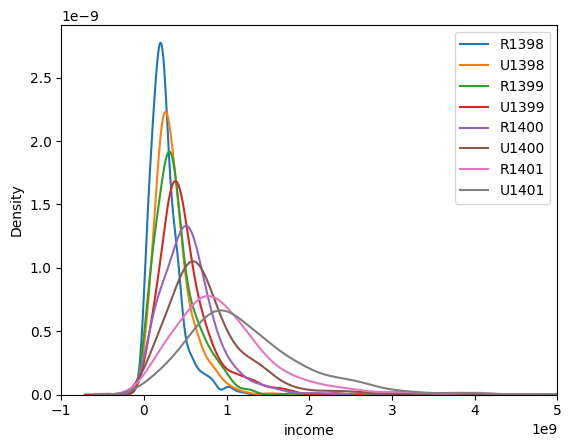

In [ ]:
years = [1398, 1399, 1400, 1401]
p_values = []
for year in years:
  R = calculate_income("R",year,5).groupby('Address').agg({'income':'sum'})
  U = calculate_income('U',year,5).groupby('Address').agg({'income':'sum'})
  sns.kdeplot(R.income,label='R'+str(year))
  sns.kdeplot(U.income, label='U'+str(year))
  plt.xlim([-1e9, 5e9])

  plt.legend()
  p_value = ttest_ind(U.income , R.income, alternative='greater',equal_var= False).pvalue
  p_values.append(p_value)
print(*[x for x in zip(years, p_values)])

برای کل کشور

(1398, 2.7375842445402273e-285) (1399, 5.479570563263966e-217) (1400, 1.7139579184908877e-205) (1401, 1.4588195691128078e-173)


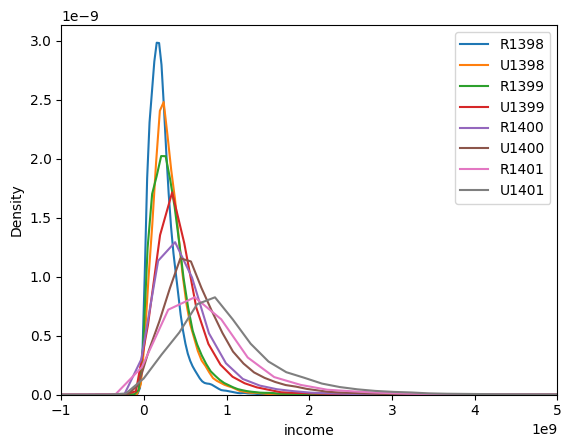

In [ ]:
years = [1398, 1399, 1400, 1401]
p_values = []
for year in years:
  R = calculate_income("R",year).groupby('Address').agg({'income':'sum'})
  U = calculate_income('U',year).groupby('Address').agg({'income':'sum'})
  sns.kdeplot(R.income,label='R'+str(year))
  sns.kdeplot(U.income, label='U'+str(year))
  plt.xlim([-1e9, 5e9])

  plt.legend()
  p_value = ttest_ind(U.income , R.income, alternative='greater',equal_var= False).pvalue
  p_values.append(p_value)
print(*[x for x in zip(years, p_values)])

In [ ]:
years = [1398, 1399, 1400, 1401]
p_values = []
P_values_normal = []
for year in years:
  R = calculate_income("R",year,province=5).groupby('Address').agg({'income':'sum'})
  U = calculate_income('U',year,province=5).groupby('Address').agg({'income':'sum'})
  P_value_normal = normaltest(U.income).pvalue,normaltest(R.income).pvalue
  P_values_normal.append(P_value_normal)
  p_value = mannwhitneyu(U.income , R.income, alternative='greater').pvalue
  p_values.append(p_value)
print('Normal_test Result')
print(*[x for x in zip(years, P_values_normal)], sep = "\n")
print('Mannwhitneyu Result')
print(*[x for x in zip(years, p_values)], sep='\n')


Normal_test Result
(1398, (5.677683756416084e-137, 2.528503748782319e-37))
(1399, (4.69812934538038e-50, 1.780546638227256e-73))
(1400, (1.3116100854365258e-124, 1.7473922626462612e-70))
(1401, (1.2958571797037887e-52, 3.490577473000356e-45))
Mannwhitneyu Result
(1398, 2.9416067262437754e-17)
(1399, 3.467401893625013e-11)
(1400, 9.227329513754086e-13)
(1401, 7.848768349157616e-12)
